In [1]:
import datasets

data = datasets.load_dataset("json", data_files="./data/c4-train.00000-of-01024.json", split="train")
print(data)




/Users/mfine/Documents/Code/exa-interview/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset({
    features: ['text', 'timestamp', 'url'],
    num_rows: 356317
})


In [6]:
data[:10]


{'text': ['Beginners BBQ Class Taking Place in Missoula!\nDo you want to get better at making delicious BBQ? You will have the opportunity, put this on your calendar now. Thursday, September 22nd join World Class BBQ Champion, Tony Balay from Lonestar Smoke Rangers. He will be teaching a beginner level class for everyone who wants to get better with their culinary skills.\nHe will teach you everything you need to know to compete in a KCBS BBQ competition, including techniques, recipes, timelines, meat selection and trimming, plus smoker and fire information.\nThe cost to be in the class is $35 per person, and for spectators it is free. Included in the cost will be either a t-shirt or apron and you will be tasting samples of each meat that is prepared.',
  'Discussion in \'Mac OS X Lion (10.7)\' started by axboi87, Jan 20, 2012.\nI\'ve got a 500gb internal drive and a 240gb SSD.\nWhen trying to restore using disk utility i\'m given the error "Not enough space on disk ____ to restore"\nB

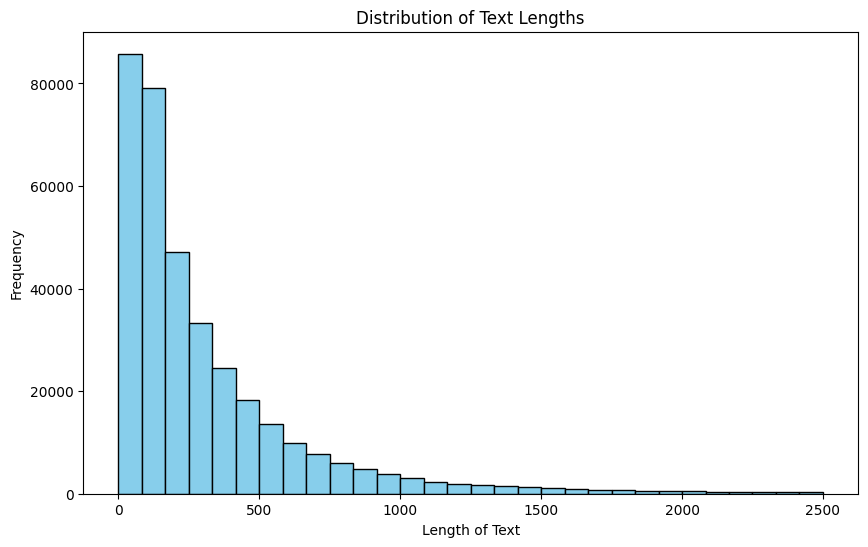

In [14]:
import matplotlib.pyplot as plt

# Calculate the length of each text entry
text_lengths = [len(text.split(" ")) for text in data["text"]]

# Plot the distribution of text lengths
plt.figure(figsize=(10, 6))
plt.hist(text_lengths, bins=30, range=(0, 2500), color='skyblue', edgecolor='black')
plt.title('Distribution of Text Lengths')
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.show()


In [31]:
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core import Document
from tqdm import tqdm

documents = [Document(text=row) for row in tqdm(data[:1000]["text"])]

splitter = SentenceSplitter(
    chunk_size=200,
    chunk_overlap=20,
)
nodes = splitter.get_nodes_from_documents(documents, show_progress=True)
passages = [n.text for n in nodes]


Parsing nodes: 100%|██████████| 1000/1000 [00:01<00:00, 859.95it/s]


In [37]:
import csv
import openai
import os
import time
from concurrent.futures import ThreadPoolExecutor
from threading import Semaphore
import json

# Configuration
MAX_THREADS = 5  # Number of threads to run in parallel
RATE_LIMIT = 5  # Max requests per second

# Initialize semaphore for rate limiting
semaphore = Semaphore(MAX_THREADS)


openai.api_key = os.getenv("OPENAI_API_KEY")
openai.api_base = "https://find-new-gpt.openai.azure.com/"
openai.api_version = "2023-05-15"
openai.api_type = "azure"

def generate_queries(passage):
    positive_prompt = """
    Given the following passage, come up with 5 varied queries that a user might ask where this passage would be the most likely result.  
    
    Respond with a list of queries only, and no other extraneous formatting or explanation. Include queries where the link between the query and answer isn't necessarily direct, but the answer is still very relevant.

    Passage: {}
    # """.format(passage)

    # negative_prompt = """
    # Given the following passage, come up with 5 varied queries that **seem** to be answered by the document -- they might share related words, or have similar structure, but are in fact NOT answered by information in the document,
    # or necessarily related at all.
    
    # Respond with a list of queries only, and no other extraneous formatting or explanation.

    # Passage: {}
    # """.format(passage)

    with semaphore:
        # Ensure that we are not sending more than RATE_LIMIT requests per second
        time.sleep(1.0 / RATE_LIMIT)
        try:
            completion = openai.ChatCompletion.create(
                engine="mfine",
                model="gpt-35-turbo",
                messages=[
                    {
                        "role": "user",
                        "content": positive_prompt
                    },
                ],
            )
            return {"passage": passage, "queries": completion.choices[0].message['content']}
        except Exception as e:
            print(e, passage)
            return None

def generate_queries_batch(passages):
    with ThreadPoolExecutor(max_workers=MAX_THREADS) as executor:
        results = list(tqdm(executor.map(generate_queries, passages), total=1000))
    with open("gpt_generated.jsonl", 'a') as f:
        for entry in results:
            if entry is not None:
                json_record = json.dumps(entry)
                f.write(f"{json_record}\n")
    return results

generate_queries_batch(passages[:1000])

 15%|█▌        | 154/1000 [00:38<03:42,  3.81it/s]

The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766 Yesterday [12 Nov], at the Shoreditch Town Hall, Dr. Macdonald, M.P., the coroner for the North- Eastern District of Middlesex, opened his inquiry relative to the death of Marie Jeanette Kelly, the woman whose body was discovered on Friday morning, terribly mutilated, in a room on the ground floor of 26, Dorset-street, entrance to which was by a side door in Miller's-court.
Superintendent T. Arnold, H Division; Inspector Abberline, of the Criminal Investigation Department, and Inspector Nairn represented the police. The deputy coroner, Mr. Hodgkinson, was present during the proceedings.
The Coroner (to the juror, severely): Do you think that we do not know what we are doing here, and that we do not know our own district? The j

 16%|█▋        | 164/1000 [00:40<03:12,  4.34it/s]

The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766 13. I did not know the deceased by the name of Kelly. I went for rent, which was in arrears. Knocking at the door, I got no answer, and I knocked again and again. Receiving no reply, I passed round the corner by the gutter spout where there is a broken window - it is the smallest window.
Charles Ledger, an inspector of police, G Division, produced a plan of the premises. Bowyer pointed out the window, which was the one nearest the entrance.
He [Bowyer] continued: There was a curtain. I put my hand through the broken pane and lifted the curtain. I saw two pieces of flesh lying on the table.
[Coroner] Where was this table ? - In front of the bed, close to it. The second time I looked I saw a body on this bed, and blood on the fl

 18%|█▊        | 176/1000 [00:43<03:29,  3.93it/s]

The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766 It had two windows in the court. Two panes in the lesser window were broken, and as the door was locked I looked through the lower of the broken panes and satisfied myself that the mutilated corpse lying on the bed was not in need of any immediate attention from me, and I also came to the conclusion that there was nobody else upon the bed, or within view, to whom I could render any professional assistance. Having ascertained that probably it was advisable that no entrance should be made into the room at that time, I remained until about 1.30p.m., when the door was broken open by McCarthy, under the direction of Superintendent Arnold. On the door being opened it knocked against a table which was close to the left-hand side of t

 18%|█▊        | 179/1000 [00:44<03:53,  3.51it/s]

The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766 Deceased had only an under- linen garment upon her, and by subsequent examination I am sure the body had been removed, after the injury which caused death, from that side of the bedstead which was nearest to the wooden partition previously mentioned. The large quantity of blood under the bedstead, the saturated condition of the palliasse, pillow, and sheet at the top corner of the bedstead nearest to the partition leads me to the conclusion that the severance of the right carotid artery, which was the immediate cause of death, was inflicted while the deceased was lying at the right side of the bedstead and her head and neck in the top right-hand corner.
the coroner said: It has come to my ears that somebody has been making a s

 25%|██▍       | 246/1000 [00:59<02:21,  5.33it/s]

The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766 AmyNicollete. LilyRay. DouglasCox.
MoanSweetviking28MishaRayNr1GoodBoy .milksquirtingtitLilyRaymilksquirtingtitdayreth .JURISEX89RomeoHotFighterJoonMaliSamaraStyle21 .VictoriaKisJUSEFFMOREDIVAextasygirl69 .MarySexxxAngelJessica28MENTATOOSHOTXmariochase33 .Ashley707DouglasCoxsouthernlisaLillyJ .MENTATOOSHOTXmatureandyounggAlisacandyyLittleAlica .davidmaxxNicolee1x0NightMan0BigCumsAriana .davetest4126MillkyBunnyTranSensualDollmariochase33 .SamaraStyle21ScarletLove4uBigCumsArianapenetrating .PrettyPocahontasSnowchaniJURISEX89LillyJ .


 25%|██▍       | 247/1000 [01:00<04:07,  3.05it/s]

The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766 TatyStarTANYAPRINCEBigeyesGreenMoanSweet .JoonMaliSnowchanilillyflower1990BellaBestBoobs .LillyJAshley707faberxxMoanSweet .CamChaseCuteLilBabemilksquirtingtitdavidmaxx .LolaAssU5CuteMariusForUCamChaseBigCumsAriana .TearMyClothesOffBastetXLionelWooddavetest4126 .TranSensualDollMOREDIVAReginaCuteVictoriaKis .MarisMuscleMoanSweetMilfKate4uVioletNimfa .penetratingRomeoHotFighterBastetXLionelWood .AliceAustinLaMaliciosaantonellarobertsLittleAlica .RomeoHotFighterMarySexxxMELANYFOXHOT23MarySexxx .


 71%|███████   | 707/1000 [02:51<01:32,  3.17it/s]

The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766 Science experiment: Try taking a deep breath through an average soda straw. Not too easy is it? This is basically what your SS has to accomplish with it's stock intake system. Now take a deep breath without that straw in your mouth (for those of you that live in a smog-choked area like Los Angeles or New York City, the State of California wants you to know that this action might be harmful to your health). If you live in a clean area of your state or country, you should feel heartily refreshed afterwards. This is how your SS will feel after you chop the stock intake system and add a new system to help it breath easier.
There are many alternatives to get more outside air into your motor, as it is optimal to duct in cooler, more

100%|██████████| 1000/1000 [04:02<00:00,  4.12it/s]


[{'passage': 'Beginners BBQ Class Taking Place in Missoula!\nDo you want to get better at making delicious BBQ? You will have the opportunity, put this on your calendar now. Thursday, September 22nd join World Class BBQ Champion, Tony Balay from Lonestar Smoke Rangers. He will be teaching a beginner level class for everyone who wants to get better with their culinary skills.\nHe will teach you everything you need to know to compete in a KCBS BBQ competition, including techniques, recipes, timelines, meat selection and trimming, plus smoker and fire information.\nThe cost to be in the class is $35 per person, and for spectators it is free. Included in the cost will be either a t-shirt or apron and you will be tasting samples of each meat that is prepared.',
  'queries': '1. "Where can I learn how to improve my BBQ skills?"\n2. "Who is teaching a beginner BBQ class in Missoula?"\n3. "What will be covered in the beginner BBQ class in Missoula?"\n4. "What is the cost of the BBQ class in Mi

In [29]:
generate_queries(passage=passages[0])

{'positive': <OpenAIObject at 0x16aaeade0> JSON: {
   "role": "assistant",
   "content": "1. \"Where can I take a BBQ class in Missoula?\"\n2. \"Who is teaching the beginner BBQ class in Missoula in September?\"\n3. \"What skills will be taught in the beginner BBQ class in Missoula?\"\n4. \"What is the cost to participate in the BBQ class in Missoula?\"\n5. \"What is included in the cost of the BBQ class in Missoula?\""
 },
 'negative': <OpenAIObject at 0x16ab64860> JSON: {
   "role": "assistant",
   "content": "1. What is the cost to attend the BBQ class in Missoula?\n2. Who is the World Class BBQ Champion teaching the beginner level class?\n3. What topics will be covered in the beginner level BBQ class?\n4. What is included in the cost of the BBQ class?\n5. When is the BBQ class taking place in Missoula?"
 }}

In [30]:
passages[0]

'Beginners BBQ Class Taking Place in Missoula!\nDo you want to get better at making delicious BBQ? You will have the opportunity, put this on your calendar now. Thursday, September 22nd join World Class BBQ Champion, Tony Balay from Lonestar Smoke Rangers. He will be teaching a beginner level class for everyone who wants to get better with their culinary skills.\nHe will teach you everything you need to know to compete in a KCBS BBQ competition, including techniques, recipes, timelines, meat selection and trimming, plus smoker and fire information.\nThe cost to be in the class is $35 per person, and for spectators it is free. Included in the cost will be either a t-shirt or apron and you will be tasting samples of each meat that is prepared.'

In [5]:
import json
import random
from tqdm import tqdm

def split_and_expand_data_updated(input_file, output_file):
    with open(input_file, 'r') as infile:
        data_lines = infile.readlines()
        
    all_queries = []
    for line in data_lines:
        data = json.loads(line)
        all_queries.extend(data['positive_queries'])
        all_queries.extend(data['negative_queries'])
    
    with open(output_file, 'w') as outfile:
        for line in tqdm(data_lines):
            data = json.loads(line)
            positive_queries = data['positive_queries']
            negative_queries = data['negative_queries']
            
            for pos_query in positive_queries:
                for i in range(2):

                    # Select 2 unique negative queries ensuring no overlap with previously selected
                    neg_queries = negative_queries[2*i:2*(i+1)]
                    neg_queries.extend(random.sample(all_queries, 3))
                    
                    # Create a new record
                    new_record = {
                        "passage": data['passage'],
                        "positive_query": pos_query,
                        "negative_queries": neg_queries,
                    }
                    
                    # Write the new record to the output file
                    json.dump(new_record, outfile)
                    outfile.write('\n')

# Specify the input and output files
input_file = 'data/gpt-generated.jsonl'
output_file = 'data/gpt-generated-expanded.jsonl'

# Call the function to process the data with updated requirements
split_and_expand_data_updated(input_file, output_file)



  0%|          | 0/8102 [00:00<?, ?it/s]

100%|██████████| 8102/8102 [00:02<00:00, 3932.63it/s]


In [6]:
from datasets import load_dataset

data =load_dataset("json", data_files="data/gpt-generated-expanded.jsonl", split="train")

Generating train split: 0 examples [00:00, ? examples/s]

In [7]:
data[0]

KeyError: "Invalid key: 0. Please first select a split. For example: `my_dataset_dictionary['train'][0]`. Available splits: ['train']"